# Imports

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorly as tl
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from tensorly.decomposition import robust_pca, tucker

from src.utils.image_controller import download_image, extract_image_frames
from src.utils.metrics_calculators import FrobeniusErrorCalculator
from src.utils.tensor_handlers import normalize_frames

# Убираем шум с картинки

In [45]:
image_url = "https://i.pinimg.com/564x/04/b2/68/04b26838bdd5e2ba54d0144558685bae.jpg"
cache_dir_image = "../.cache/image"

In [46]:
image_path = download_image(image_url, cache_dir_image)
image_frames = extract_image_frames(image_path)
image_frames.shape

Изображение уже загружено и закешировано: ../.cache/image/04b26838bdd5e2ba54d0144558685bae.jpg


(564, 564, 3)

In [52]:
def add_speckle_noise(image):
    row, col, ch = image.shape
    rng = np.random.default_rng(42)
    gauss = rng.standard_normal((row, col, ch))
    noisy = image + image * gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)


def add_salt_pepper_noise(image, prob=0.05):
    noisy = np.copy(image)
    rng = np.random.default_rng(42)
    salt_pepper_noise = rng.random(image.shape)
    noisy[salt_pepper_noise < prob / 2] = 0
    noisy[salt_pepper_noise > 1 - prob / 2] = 255
    return noisy


def add_gaussian_noise(image, mean=0, var=1.0, noise_factor=1.0):
    rng = np.random.default_rng(42)
    noise = rng.normal(mean, var**0.5, image.shape)
    noisy_image = image + noise_factor * noise * 255
    return noisy_image.astype(np.uint8)


def denoise_image_tucker(image, rank):
    image_tensor = tl.tensor(image)
    core, factors = tucker(image_tensor, rank=rank)
    denoised_image = tl.tucker_to_tensor((core, factors))
    return normalize_frames(denoised_image)


def denoise_image_rtpca(image, tol=1e-7, reg_e=0.1):
    image_tensor = tl.tensor(image.astype(np.float64))
    low_rank, sparse = robust_pca(image_tensor, tol=tol, reg_E=reg_e)
    denoised_image = tl.to_numpy(low_rank)
    return normalize_frames(denoised_image)

In [48]:
# noise_image_frames = add_gaussian_noise(image_frames, noise_factor=0.08)

In [49]:
noise_image_frames = add_salt_pepper_noise(image_frames)

In [50]:
denoised_image_frames_tucker = denoise_image_tucker(noise_image_frames, rank=[300, 300, 3])

In [53]:
denoised_image_frames_rtpca = denoise_image_rtpca(noise_image_frames)

In [54]:
frobenius_tucker = FrobeniusErrorCalculator.calculate(image_frames, denoised_image_frames_tucker)
frobenius_rtpca = FrobeniusErrorCalculator.calculate(image_frames, denoised_image_frames_rtpca)
print(frobenius_tucker, frobenius_rtpca)

91.57612286109728 16.917706790123948


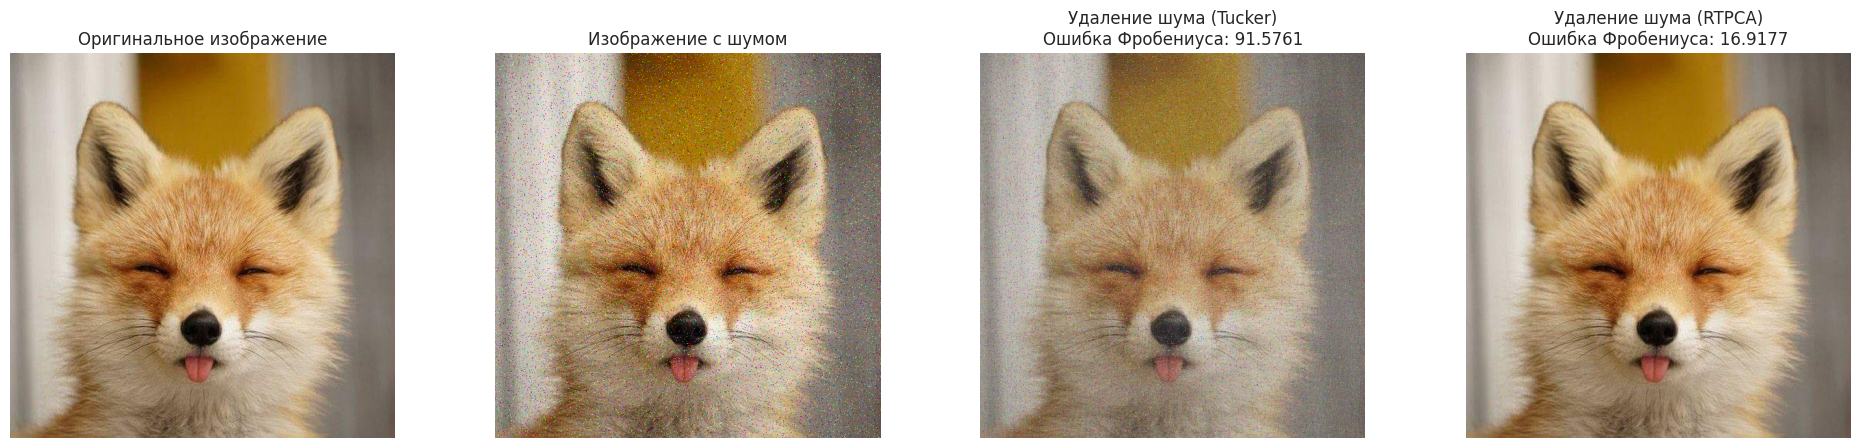

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].imshow(image_frames)
axes[0].set_title("Оригинальное изображение")
axes[0].axis("off")

axes[1].imshow(noise_image_frames)
axes[1].set_title("Изображение с шумом")
axes[1].axis("off")

axes[2].imshow(denoised_image_frames_tucker)
axes[2].set_title(f"Удаление шума (Tucker)\nОшибка Фробениуса: {frobenius_tucker:.4f}")
axes[2].axis("off")

axes[3].imshow(denoised_image_frames_rtpca)
axes[3].set_title(f"Удаление шума (RTPCA)\nОшибка Фробениуса: {frobenius_rtpca:.4f}")
axes[3].axis("off")

plt.show()

# Исследование данных в низкой размерности

In [38]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

In [39]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [40]:
pca_3d = PCA(n_components=3)
components_3d = pca_3d.fit_transform(iris.data)
df_pca = pd.DataFrame()
df_pca["species"] = iris.target
df_pca["PCA1"] = components_3d[:, 0]
df_pca["PCA2"] = components_3d[:, 1]
df_pca["PCA3"] = components_3d[:, 2]

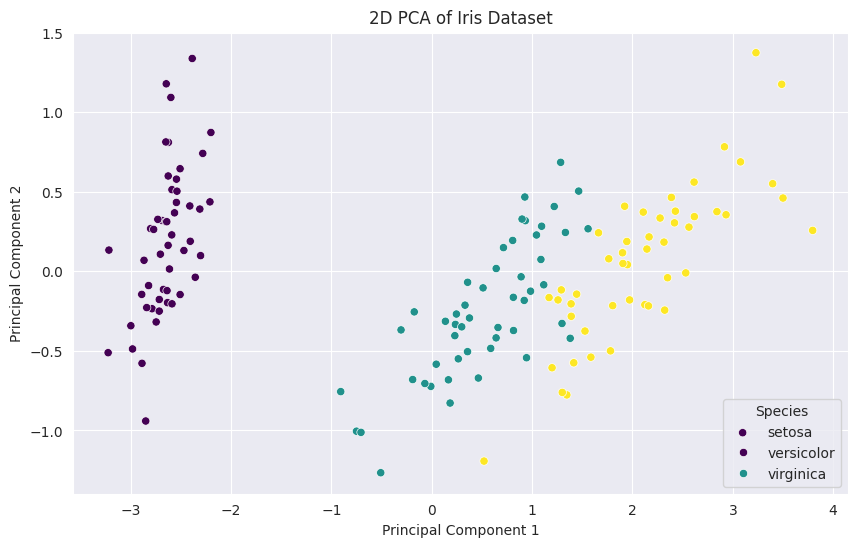

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="species", palette="viridis", data=df_pca)
plt.legend(title="Species", labels=iris.target_names)
plt.title("2D PCA of Iris Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [42]:
fig = px.scatter_3d(
    df_pca,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color="species",
    title="3D PCA Visualization of Iris Dataset",
    labels={"PCA1": "Principal Component 1", "PCA2": "Principal Component 2", "PCA3": "Principal Component 3"},
    symbol="species",
)
fig.update_layout(legend_title_text="Species")
fig.show()